In [1]:
import numpy as np
import os
import torch
import matplotlib.pyplot as plt
from brain_block.random_initialize import connect_for_block, connect_for_multi_sparse_block
from brain_block.block import block
from analysis.spike_statistics import *
from scipy.ndimage import gaussian_filter1d
from scipy.io import loadmat
%matplotlib inline


# grid search on some parameter points to explore spike dynamics of dti network of d500
## for d500 \math
##   172 * ampa + 600 * nmda = 1
##   10 * gabaA + 180 * gabaB = 1
## range(0, 1), range*(0, 1), 10 grid points each axis, total 100 points, only document the fisrt 25 points.

----------
pcc
[[ 2.11927226e-03  1.98584769e-03 -1.84133191e-03  4.83108371e-04
   8.13621436e-04]
 [-1.42799385e-04  2.55124806e-04 -3.39915432e-04 -3.92311125e-04
   2.72701592e-03]
 [ 6.46715059e-04  1.26308187e-03 -2.81437775e-04  4.02837512e-04
  -4.01909912e-04]
 [-1.16714083e-03  4.31280428e-04 -8.80519759e-05 -5.56926287e-04
   1.02406566e-03]
 [-6.62490043e-04  1.52078936e-04  7.96578212e-04 -1.15213186e-04
  -6.87614831e-04]]
----------


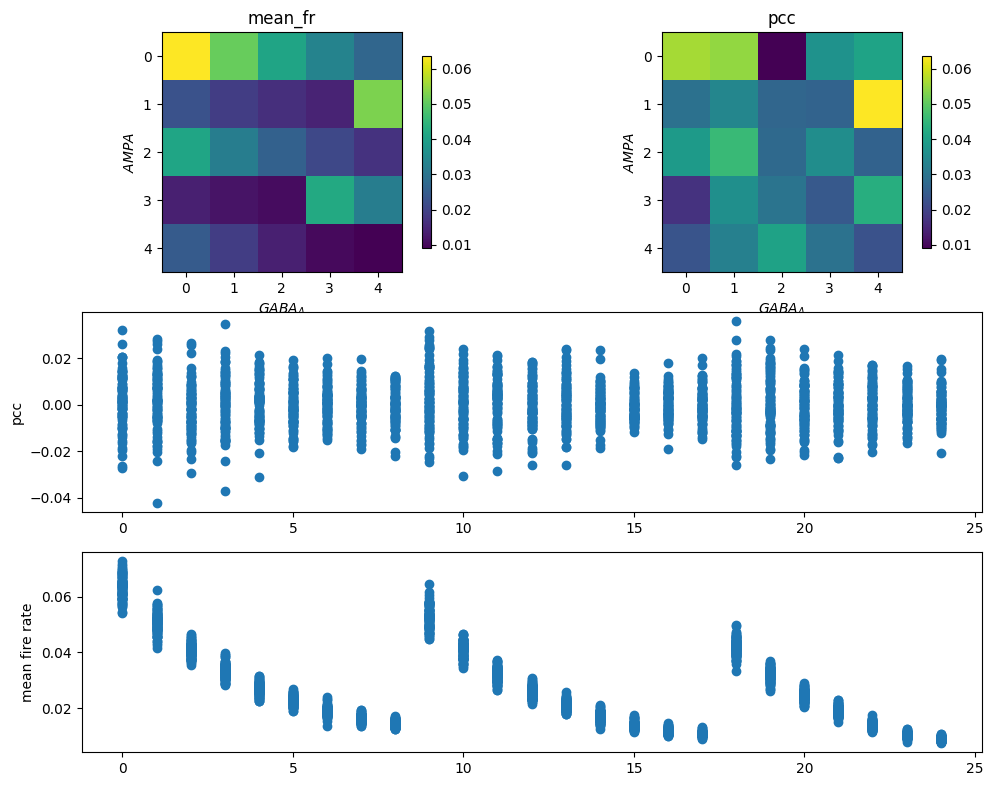

In [3]:
file = np.load("../data/grid_search_on_region_d500_1e7.npz")
ampa_contribution = file["ampa_contribution"]
gabaA_contribution = file["gabaA_contribution"]
mean_fr = file["mean_fr"]
pcc = file["pcc"]
fig = plt.figure(figsize=(10, 8), dpi=100)
ax = fig.add_axes([0.05, 0.65, 0.4, 0.3])
im = ax.imshow(mean_fr.mean(axis=1).reshape((5, 5)))
fig.colorbar(im, ax=ax, shrink=0.8)
ax.set_xlabel(r"$GABA_{A}$")
ax.set_ylabel(r"$AMPA$")
ax.set_title("mean_fr")
ax = fig.add_axes([0.55, 0.65, 0.4, 0.3])
ax.imshow(pcc.mean(axis=1).reshape((5,5)))
fig.colorbar(im, ax=ax, shrink=0.8)
ax.set_xlabel(r"$GABA_{A}$")
ax.set_ylabel(r"$AMPA$")
ax.set_title("pcc")
x = np.arange(25)
x = np.repeat(x, 90)
mean_fr = np.stack([x, mean_fr.reshape(-1)], axis=0)
pcc_total = np.stack([x, pcc.reshape(-1)], axis=0)
ax = fig.add_axes([0.05, 0.05, 0.9, 0.25])
ax.scatter(mean_fr[0], mean_fr[1], marker="o")
ax.set_ylabel("mean fire rate")
ax = fig.add_axes([0.05, 0.35, 0.9, 0.25])
ax.scatter(pcc_total[0], pcc_total[1], marker="o")
ax.set_ylabel("pcc")
print("-"*10)
print("pcc")
print(pcc.mean(axis=1).reshape((5,5)))
print("-"*10)

# grid search on some parameter points to explore spike dynamics of dti network of d300
## for d300 \math
##   102 * ampa + 500 * nmda = 1
##   6 * gabaA + 108 * gabaB = 1
## range(0.5, 1), range*(0, 0.5), 5 grid points each axis, total 25 points.

----------
pcc
[[9.65005828e-01 2.32377498e-03 2.06789171e-03 1.68979286e-03
  4.54096706e-04]
 [9.79142729e-01 9.10798932e-01 1.45007418e-03 1.47759532e-03
  2.85696928e-04]
 [9.85127529e-01 9.62231801e-01 7.29930815e-01 1.85662964e-01
  4.40694666e-04]
 [9.88417939e-01 9.76514705e-01 8.96064326e-01 4.77036173e-01
  1.59839072e-01]
 [9.89194468e-01 9.82591626e-01 9.50824738e-01 7.30613400e-01
  3.27003619e-01]]
----------


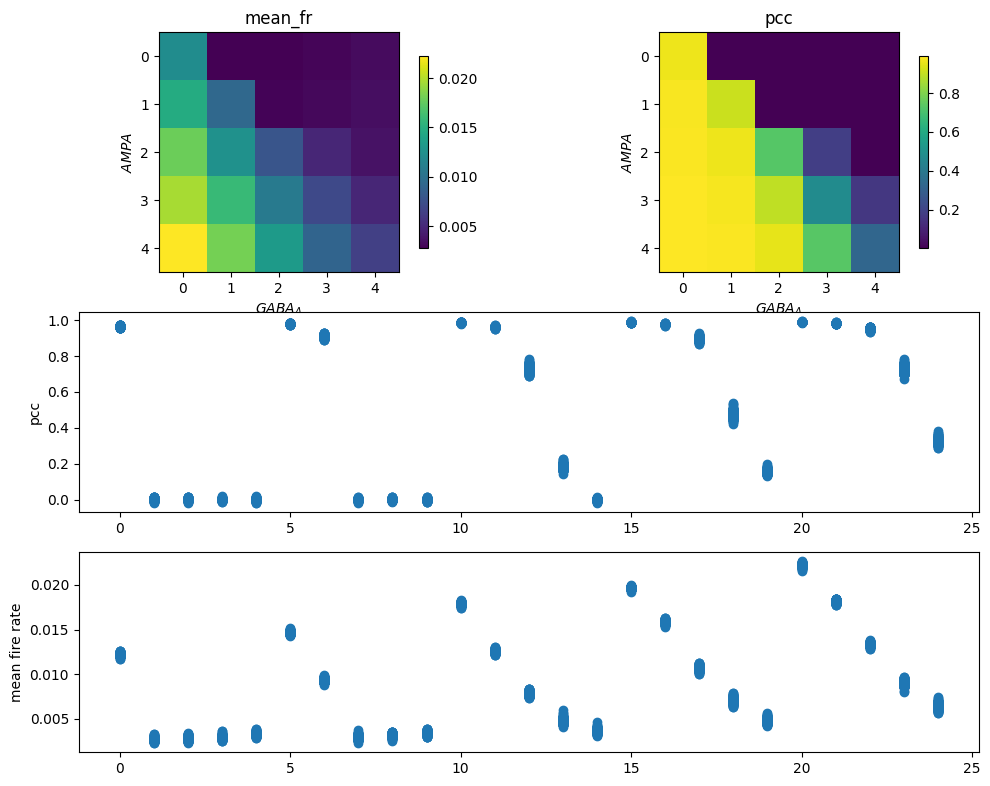

In [6]:
file = np.load("../data/grid_search_on_region_d300_1e7.npz")
mean_fr = file["mean_fr"]
ampa_contribution = np.linspace(0.5, 1., num=50, endpoint=True)
gabaA_contribution = np.linspace(0., 0.5, num=50, endpoint=True)
pcc = file["pcc"]
fig = plt.figure(figsize=(10, 8), dpi=100)
ax = fig.add_axes([0.05, 0.65, 0.4, 0.3])
im = ax.imshow(mean_fr.mean(axis=1).reshape((5, 5)))
fig.colorbar(im, ax=ax, shrink=0.8)
ax.set_xlabel(r"$GABA_{A}$")
ax.set_ylabel(r"$AMPA$")
ax.set_title("mean_fr")
ax = fig.add_axes([0.55, 0.65, 0.4, 0.3])
im = ax.imshow(pcc.mean(axis=1).reshape((5,5)))
fig.colorbar(im, ax=ax, shrink=0.8)
ax.set_xlabel(r"$GABA_{A}$")
ax.set_ylabel(r"$AMPA$")
ax.set_title("pcc")
x = np.arange(25)
x = np.repeat(x, 90)
mean_fr = np.stack([x, mean_fr.reshape(-1)], axis=0)
pcc_total = np.stack([x, pcc.reshape(-1)], axis=0)
ax = fig.add_axes([0.05, 0.05, 0.9, 0.25])
ax.scatter(mean_fr[0], mean_fr[1], marker="o")
ax.set_ylabel("mean fire rate")
ax = fig.add_axes([0.05, 0.35, 0.9, 0.25])
ax.scatter(pcc_total[0], pcc_total[1], marker="o")
ax.set_ylabel("pcc")
print("-"*10)
print("pcc")
print(pcc.mean(axis=1).reshape((5,5)))
print("-"*10)

In [5]:
ampa_contribution = np.linspace(0.5, 1., num=50, endpoint=True)
gabaA_contribution = np.linspace(0., 0.5, num=50, endpoint=True)
contribution = np.stack(np.meshgrid(ampa_contribution, gabaA_contribution, indexing='ij'), axis=-1).reshape(
    (-1, 2))
ampa_contribution = contribution[:, 0]
gabaA_contribution = contribution[:, 1]
ampa = ampa_contribution / 102
nmda = (1 - ampa_contribution) / 500
gabaA = gabaA_contribution / 6
gabaB = (1 - gabaA_contribution) / 108
para = np.stack([ampa, nmda, gabaA, gabaB], axis=1)
sample_idx = np.arange(5, 50, 10, dtype=np.int8)
sample_idx = np.stack(np.meshgrid(sample_idx, sample_idx, indexing="ij"), axis=-1).reshape((-1, 2))
idx = 19
a, b = sample_idx[idx]
print("row, column:", a, b)
specific_gui = para[a * 50 + b]
print("specified_gui:", specific_gui)

row, column: 35 45
specified_gui: [0.00840336 0.00028571 0.07653061 0.00500756]
